# Hands-on Machine Learning - Chapter 8 
# Dimensionality Reduction

# Setup

In [18]:
# Python version 3.5 or above required 
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn 0.20 or above required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os 

# Seed random number generator for consistent outputs across runs
np.random.seed(42)

# Plotting 
%matplotlib inline 
import matplotlib.pyplot as plt 
import matplotlib as mpl 
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Saving figures 
ROOT_DIR = "."
IMAGES_PATH = os.path.join(ROOT_DIR, 'images')
os.makedirs(IMAGES_PATH, exist_ok=True)

# Function for saving figures
def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + '.' + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
# Ignore warnings
import warnings
warnings.filterwarnings(action='ignore', message='^internal gelsd')

# Projection Methods

## Building 3D Dataset

In [34]:
# Different seed for random number generator
np.random.seed(4)

m = 60                     # Number of examples
w1, w2 = 0.1, 0.3          # Weights for x and y axes 
noise = 0.1                # Gaussian noise coefficient 

# Every point will be at a different angle 
angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5

# Creating numpy array to store feature values
X = np.empty((m, 3))

# First feature - cos and sin of angle plus some noise
X[:, 0] = np.cos(angles) + np.sin(angles) / 2 + noise * np.random.randn(m) / 2

# Second feature - Only sin of the angle plus some noies
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2 

# Third feature - Linear combination of the other two features
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

## PCA with SVD

Using singular value decomposition to find the unit vectors in direction of the principal components. SVD decomposes a matrix of features `X` into a product of three separate matrices, `U`, `Sigma`, and `V_t`. `V_t` is a matrix consisting of principal component unit vectors as **rows**. This is what we're interested in

In [35]:
# First, center the training data - axis=0 means each feature (column) is normalized
X_centered = X - X.mean(axis=0)

# Singular value decomposition using built-in `numpy` function
U, s, Vt = np.linalg.svd(X_centered)

# First principal component is first column of V_t after transposition
c1 = Vt.T[:, 0]

# Second principal component is orthogonal to first, is second column of Vt after transposition
c2 = Vt.T[:, 1]

### Confirming SVD Results

To confirm that the three matrices returned by the `svd` function are correct, we can try multiplying these matrices with each other and comparing the result to the centered version of `X`. 

The only caveat is that `sklearn` returns `s` as a row vector where each column represents the non-zero diagonal element in the principal diagonal of that column. This is more efficient, because if the `S` is a diagonal matrix, there's no need to return the non-zero non-diagonal elements.

However, to get back the `X_centered` matrix from the matrices returned by `svd`, we will have to transform `s` back into diagonal matrix form.

In [36]:
# Number of examples and features in the training data
m, n = X.shape 

In [37]:
# Creating a new matrix for `S` - has same shape as the centered feature matrix
S = np.zeros(X_centered.shape)

# Transform to a diagonal matrix - only first `n` rows and cols will be same as a diagonal version of `S`
S[:n, :n] = np.diag(s)

In [38]:
# Is the product of U, S, and Vt close enough to the centered features?
np.allclose(X_centered, U.dot(S).dot(Vt))

True

### Reducing Dimensionality with SVD

In [39]:
# Get the unit vectors of the first two principal components
W2 = Vt.T[:, :2]

# Multiply by centered features to reduce them from 3D to 2D
X2D = X_centered.dot(W2)

In [40]:
# Remember these features for later so we can compare them to built-in PCA results
X2D_using_svd = X2D

## PCA with `Scikit-Learn`

Using `PCA` class in `scikit-learn`, the process described above^ is very straightforward. Don't even have to do mean centering.

In [41]:
from sklearn.decomposition import PCA

In [42]:
# Instantiate a PCA object - specifying we want 2 components that retain maximum variance
pca = PCA(n_components=2)

# Fit to the training data - no centering required
X2D = pca.fit_transform(X)

In [43]:
# Observe the shape of the X2D matrix - now 2D instead of 3D
X2D[:5]

array([[ 1.26203346,  0.42067648],
       [-0.08001485, -0.35272239],
       [ 1.17545763,  0.36085729],
       [ 0.89305601, -0.30862856],
       [ 0.73016287, -0.25404049]])

In [44]:
# Are these results similar to the components derived 
X2D_using_svd[:5]

array([[-1.26203346, -0.42067648],
       [ 0.08001485,  0.35272239],
       [-1.17545763, -0.36085729],
       [-0.89305601,  0.30862856],
       [-0.73016287,  0.25404049]])

Magnitudes of reduced features are the same in components returned by both `svd` and `PCA` , but the direction of the first axis is different. This is normal: the plane defined by the principal components is almost always the same, but the directions of the principal components are not.

In [45]:
# Can confirm that magnitudes of transformed features virtually identical
np.allclose(np.abs(X2D), np.abs(X2D_using_svd))

True

## Recovering Original Features - `PCA`

It is possible to recover the original features `X` from features whose dimensionality has been reduced using `PCA` as long as we have access to the principal components used to transform them. 

We know that `reduced_features` = `X` $\times$ `W_d` where `W_d` is the `d`-dimensional matrix consisting of the `d` principal components we are using for dimensionality reduction. 

The original features can be recovered using `original_features` = `reduced_features` $\times$ `W_d_transpose`.

This is what the `inverse_transform` function of the `PCA` object does.

In [46]:
X3D_inv = pca.inverse_transform(X2D)

There will have been some loss of information during the dimensionality reduction, so it is impossible to recover the original data exactly.

This is confirmed by the following cell.

In [47]:
np.allclose(X3D_inv, X)

False

### Reconstruction Error

The difference between the original features and the features reconstructed using a `PCA` object is called the **reconstruction error**. Concretely, it is the MSE between the original and reconstructured features.

In [48]:
np.mean(np.sum(np.square(X3D_inv - X), axis=1))

0.01017033779284855

## Recovering Original Features - SVD 

Can also recover the original features using the matrices returned by the `svd` method.

In [50]:
X3D_inv_using_svd = X2D_using_svd.dot(Vt[:2, :])

Reconstructions from `PCA` and `SVD` are not the same because the `SVD` approach does not account for mean centering, whereas `Sklearn PCA` does.

In [51]:
# Without accounting for mean centering
np.allclose(X3D_inv_using_svd, X3D_inv)

False

In [53]:
# After accounting for mean subtraction 
np.allclose(X3D_inv_using_svd, X3D_inv - pca.mean_)

True

## Accessing Principal Components

In [54]:
# PCA objects will remember the unit vectors it computed
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

In [55]:
# Compare these to the vectors returned by the svd method
Vt[:2]

array([[ 0.93636116,  0.29854881,  0.18465208],
       [-0.34027485,  0.90119108,  0.2684542 ]])

Axes are flipped. This is consistent with our previous observations: the **directions** of the principal component vectors are not deterministic, but the plane they define is. 

## Explained Variance Ratio
 
The whole point of PCA is to reduce the dimensionality of data by projecting it onto lower dimensional axes or hyperplanes while preserving the highest amount of variance in the original data. Concretely, this is done by finding the planes for which the MSE between original data and projected data is minimal. 

In [56]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

The previous cell shows that the first principal component (or rather, the plane define by the first principal component) accounts for 84.24% of the variance in the original data, with the second principal component accounting for 14.6% of the remaining variance. 

So projecting from 3D to 2D has preserved ~98.9% of the variance in the original data.

In [60]:
(1 - np.sum(pca.explained_variance_ratio_)) * 100

1.1195535570688975

# Manifold Learning

## Swiss Roll Dataset

In [66]:
from sklearn.datasets import make_swiss_roll

In [68]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

Saving figure swiss_roll_plot


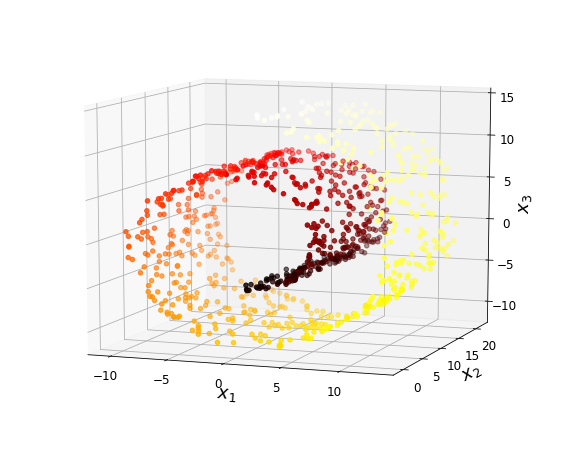

In [77]:
# Define axes limits
axes = [-11.5, 14, -2, 23, -12, 15]

# Create a new 3D figure
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Create scatter plot of the different features - points closer to the 'center' are darker
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)

# Set initial view of the 3d plot
ax.view_init(10, -70)

# Annotate axes
ax.set_xlabel('$x_1$', fontsize=18)
ax.set_ylabel('$x_2$', fontsize=18)
ax.set_zlabel('$x_3$', fontsize=18)

# Set axes limits
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

# Save the figure
save_fig('swiss_roll_plot')
plt.show()

## Swiss Roll - Projection vs Unrolling 

This example demonstrates that projecting training samples from a higher dimensional space to a lower dimensional hyperplane may not always be the best approach. Sometimes, it is more useful to model the manifold of the high dimensional data i.e. the lower dimensional 2D subspace which lies in the higher dimensional space, and which can be bent, twisted, and transformed to form the data in the higher dimensional space. 

With projection, samples of different 'colors' (or classes) are squashed together and are no longer separable. But by modeling the 2D manifold onto which the 3D swiss roll can be fit, we can still retain the different classes in the data.

Saving figure squished_swiss_roll_plot


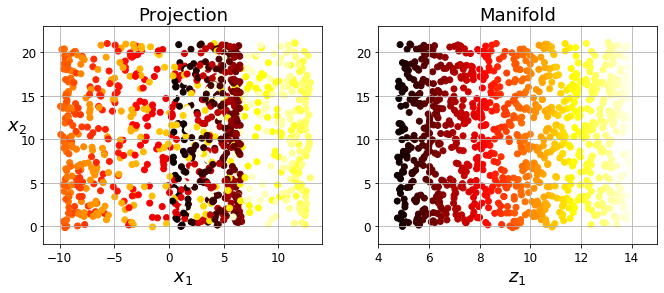

In [79]:
plt.figure(figsize=(11, 4))

# First plot - projection - just drop the z axis
plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis(axes[:4])   # Limit to x and y axes
plt.xlabel('$x_1$', fontsize=18)
plt.ylabel('$x_2$', fontsize=18, rotation=0)
plt.title('Projection', fontsize=18)
plt.grid(True)

# Second plot - manifold - unrolling the data 
plt.subplot(122)
plt.scatter(t, X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel('$z_1$', fontsize=18)
plt.title('Manifold', fontsize=18)
plt.grid(True)

# Save the figure
save_fig('squished_swiss_roll_plot')
plt.show()

# MNIST Compression

This example will demonstrate how to use the `PCA` class in `sklearn` to 
- specify the **number** of principal components we wish to retain.
- specify the **proportion** of variance in the original data we wish to retain.
- reconstruction of original samples from PCA-compressed data. 

## Loading Data

In [82]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

In [81]:
# Fetch data as 784-dimensional vectors of pixel intensities
mnist = fetch_openml('mnist_784', version=1)

# Set targets to integers
mnist.target = mnist.target.astype(np.uint8)

In [83]:
# Extract data and targets
X = mnist['data']
y = mnist['target']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y)

## PCA - Manual Method

We can manually find the number of principal components that will preserve a specified proportion of the input data's variance. The steps involved are 
1. Instantiate a PCA object.
2. Fit it to the training data.
3. Find the cumulative sum of explained variance (as a ratio) for each PC in sequence. 
4. Find the first PC for which the cumulative explained variance exceeds the thresholds. This is the dimension we want the data to be transformed to. 
5. Fit and transform the data again using this number of components.

In [84]:
# Instantiate a PCA object
pca = PCA()

# Fit to the training data
pca.fit(X_train)

# Find the cumulative sum of explained variance
cum_sum = np.cumsum(pca.explained_variance_ratio_)

# Find the dimensionality at which the target variance is achieved
d = np.argmax(cum_sum >= 0.95) + 1

# Print it 
d

154

## PCA - Graphical Method

Instead of using a predefined threshold value, we can also plot the trend in the cumulative explained variance ratio with increasing number of components. 

There will a point (or elbow) in the graph where the cumulative explained variance begins to increase at a far lower rate than before. This is the **intrinsic** dimensionality of the data. We will find that this elbow may actually occur far below the dimensionality for a specified threshold.

Saving figure explained_variance_plot


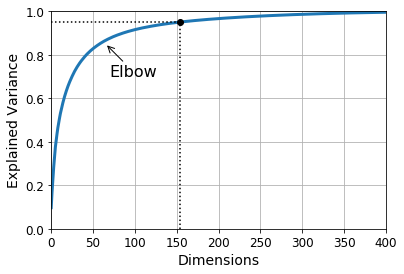

In [87]:
plt.figure(figsize=(6, 4))
plt.plot(cum_sum, linewidth=3)
plt.axis([0, 400, 0, 1])   
plt.xlabel('Dimensions')
plt.ylabel('Explained Variance')

# Straight lines identifying x and y axis values for 0.95 variance
plt.plot([d, d], [0, 0.95], 'k:')
plt.plot([0, d], [0.95, 0.95], 'k:')

# Black dot at intersection of horizontal and vertical lines to show 0.95 variance point
plt.plot(d, 0.95, 'ko')

# Arrow pointing at the elbow in the graph
plt.annotate('Elbow', xy=(65, 0.85), xytext=(70, 0.7), 
            arrowprops=dict(arrowstyle='->'), fontsize=16)
plt.grid(True)
save_fig('explained_variance_plot')
plt.show()

## PCA - Variance Method

Can also specify the proportion of variance we wish to preserve. PCA will automatically find the number of components required to achieve this variance.

In [88]:
# Instantiate PCA with n_components set to required variance pctage
pca = PCA(n_components=0.95)

In [89]:
# Transform the training data with this PCA
X_reduced = pca.fit_transform(X_train)

In [91]:
# Will still give 154 - didn't have to search for this with cumsum manually
pca.n_components_

154

In [92]:
# Confirming that required variance is preserved
np.sum(pca.explained_variance_ratio_)

0.9503684424557437

## Reconstruction 

Will demonstrate that it is possible to reconstruct the original MNIST images (with some data loss) using the 154-dimensional vectors.

In [93]:
# Instantiate PCA object that will have 154 components that preserve most variance
pca = PCA(n_components = 154)

# Transform the original training data
X_reduced = pca.fit_transform(X_train)

# Reconstructed data
X_recovered = pca.inverse_transform(X_reduced)

In [94]:
def plot_digits(instances, images_per_row=5, **options):
    # Width and height of each picture is 28 pixels
    size=28
    
    # Ims per row = function argument or number of instances, whichever is smaller
    # Ensures only one row if < 5 images
    images_per_row = min(len(instances), images_per_row)
    
    # Create a list of all images reshaped as 28 x 28 numpy arrays
    images = [instance.reshape(size,size) for instance in instances]
    
    # Number of rows = total instances / images_per_row + one additional row
    n_rows = (len(instances) - 1) // images_per_row + 1
    
    # Empty list to resha
    row_images = []
    
    # How many cells in the grid will be empty?
    n_empty = n_rows * images_per_row - len(instances) 

    # Append this to the list of images
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Saving figure mnist_compression_plot


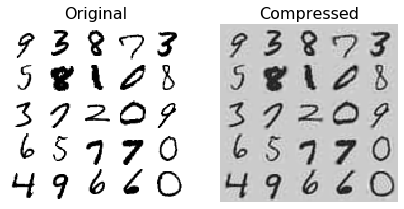

In [95]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

save_fig("mnist_compression_plot")

In [96]:
# Remember the reduced version of the MNIST images
X_reduced_pca = X_reduced

## Incremental PCA

The problem with `PCA` is that, under the hood, it uses `SVD`, which requires the entire training data (`X`) to be able to fit in memory. This isn't often the case with real world, large-scale datasets. 

One workaround for this problem is to use **incremental PCA** - a form of PCA in which small batches of input data are read into memory at any given time and used to incrementally or iteratively update the principal component vectors. 

After the entire data has been processed, the final principal component vectors are then fit to the training data.

Demonstrating this using the `MNIST` dataset.

In [98]:
from sklearn.decomposition import IncrementalPCA

In [99]:
# Number of batches to process
n_batches = 100

# Instantiate incremental PCA object 
inc_pca = IncrementalPCA(n_components=154)

# Fit iteratively to every batch of input data
for X_batch in np.array_split(X_train, n_batches):
    # One dot printed per batch, on the same line
    print(".", end="") 
    
    # Partially fit to the current batch
    inc_pca.partial_fit(X_batch)

....................................................................................................

In [100]:
# Transform the training data after all batches processed 
X_reduced = inc_pca.transform(X_train)

In [101]:
# Save these as a separate variable - for comparison with original PCA later
X_reduced_inc_pca = X_reduced

Comparing results of the original `PCA` and `IncrementalPCA` objects. 

Mean values of each principal component will be the same, but not actual values. This is because incremental PCA is always an approximation.

In [102]:
np.allclose(pca.mean_, inc_pca.mean_)

True

In [103]:
# Values aren't identical - only means are
np.allclose(X_reduced_pca, X_reduced_inc_pca)

False

## `memmap`

`memmap` is a `numpy` method which will load features/data from a file on disk and apply incremental PCA to it.

In [104]:
# Creating a `memmap` structure and copying MNIST data into it 
filename = 'my_mnist.data'
m, n = X_train.shape

X_mm = np.memmap(filename, dtype='float32', mode='write', shape=(m, n))
X_mm[:] = X_train

In [105]:
# Deleting the `memmap` object, triggering its Python finalizer -> ensures data is saved to disk
del X_mm

In [106]:
# A second program uses data from disk for training
X_mm = np.memmap(filename, dtype='float32', mode='readonly', shape=(m, n))

batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=525, copy=True, n_components=154, whiten=False)

## Randomized PCA 

`PCA`, by default, will always attempt to find an 'approximate' solution to the SVD equation rather than an exact one if the number of required dimensions `d` is less than 80% of either the number of training examples `m` or the number of features `n`.

This is because it reduces complexity from $\mathcal{O}(m\times n^2) + \mathcal{O}(n^3)$ to $\mathcal{O}(m\times d^2) + \mathcal{O}(d^3)$, which is faster since $d << n$.

In [107]:
rnd_pca = PCA(n_components=154, svd_solver='randomized', random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

## Time Complexity 

Comparing the time complexity of 
- regular PCA 
- incremental PCA
- randomized PCA 

for various number of principal components.

In [108]:
# For timing
import time

In [109]:
for n_components in (2, 10, 154):
    print("n_components =", n_components)
    # Instantiating the different PCA objects
    regular_pca = PCA(n_components=n_components)
    inc_pca = IncrementalPCA(n_components=n_components, batch_size=500)
    rnd_pca = PCA(n_components=n_components, random_state=42, svd_solver='randomized')
    
    # For each PCA, find the time taken to fit
    for pca in (regular_pca, inc_pca, rnd_pca):
        t1 = time.time()     # Start time
        pca.fit(X_train)     # Fit
        t2 = time.time()     # End time
        
        # Print the time taken for this PCA's fit operation
        print("    {}: {:.1f} seconds".format(pca.__class__.__name__, t2 - t1))

n_components = 2
    PCA: 2.6 seconds
    IncrementalPCA: 16.2 seconds
    PCA: 2.6 seconds
n_components = 10
    PCA: 2.8 seconds
    IncrementalPCA: 15.7 seconds
    PCA: 3.2 seconds
n_components = 154
    PCA: 7.3 seconds
    IncrementalPCA: 25.0 seconds
    PCA: 7.6 seconds


### PCA and Randomized PCA 

In [110]:
# Lists to store fitting times for each sample size for both pca and rpca
times_rpca = []
times_pca = []

# Defining sizes of datasets for which to fit
sizes = [1000, 10000, 20000, 30000, 40000, 50000, 70000, 100000, 200000, 500000]

# For each training set size specified 
for n_samples in sizes:
    print("Fitting for size", n_samples)
    
    # Make some random 5-D data
    X = np.random.randn(n_samples, 5)
    
    # Instantiate a randomized PCA 
    pca = PCA(n_components=2, svd_solver='randomized', random_state=42)
    
    # Time it 
    t1 = time.time()
    pca.fit(X)
    t2 = time.time() 
    
    # Append training time to RPCA list
    times_rpca.append(t2 - t1)
    
    # Instantiate a new PCA object - SVD solver will be 'auto'
    pca = PCA(n_components=2)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

Fitting for size 1000
Fitting for size 10000
Fitting for size 20000
Fitting for size 30000
Fitting for size 40000
Fitting for size 50000
Fitting for size 70000
Fitting for size 100000
Fitting for size 200000
Fitting for size 500000


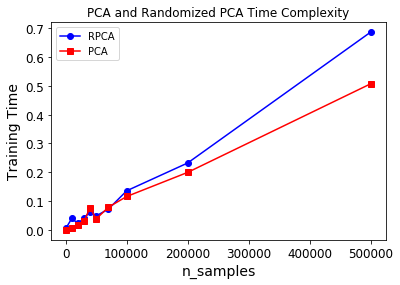

In [113]:
# Plotting data
plt.plot(sizes, times_rpca, 'b-o', label='RPCA')
plt.plot(sizes, times_pca, 'r-s', label='PCA')
plt.xlabel('n_samples')
plt.ylabel('Training Time')
plt.legend(loc='upper left')
plt.title('PCA and Randomized PCA Time Complexity')
plt.show()

Why does PCA have lower training time than randomized PCA? I though the whole point of randomized PCA was for there to be an improvement in time complexity.

`d` is always 2. Number of input features `n` is always 5. Number of training examples `m` increases. 

### Time Complexity - PCA vs RPCA - Features

Exploring the effect of number of featues on the time complexity of PCA and RPCA. 

Text(0.5, 1.0, 'PCA and Randomized PCA time complexity ')

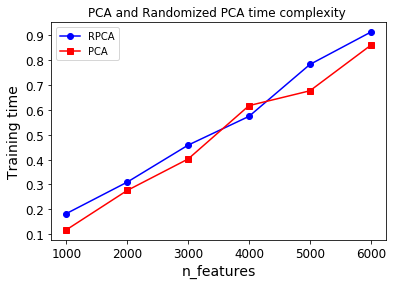

In [114]:
times_rpca = []
times_pca = []
sizes = [1000, 2000, 3000, 4000, 5000, 6000]
for n_features in sizes:
    X = np.random.randn(2000, n_features)
    pca = PCA(n_components = 2, random_state=42, svd_solver="randomized")
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_rpca.append(t2 - t1)
    pca = PCA(n_components = 2)
    t1 = time.time()
    pca.fit(X)
    t2 = time.time()
    times_pca.append(t2 - t1)

plt.plot(sizes, times_rpca, "b-o", label="RPCA")
plt.plot(sizes, times_pca, "r-s", label="PCA")
plt.xlabel("n_features")
plt.ylabel("Training time")
plt.legend(loc="upper left")
plt.title("PCA and Randomized PCA time complexity ")

# Kernel PCA

PCA is useful when we want to reduce the dimensionality of a higher-dimensional set of features to a lower dimension. This is a linear projection.

When using the kernel trick in SVMs, we were mapping training instances into a higher dimensional feature space in which a linear decision boundary corresponded to a non-linear decision boundary of the lower-dimensional feature space. 

We're doing the same thing here. The only difference is that we're performing a complex non-linear projection instead of finding a complex non-linear decision boundary.

In [115]:
# Loading data 
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [116]:
from sklearn.decomposition import KernelPCA

In [117]:
rbf_pca = KernelPCA(n_components=2, kernel='rbf', gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

## Visualizing PCA Kernels

In [118]:
from sklearn.decomposition import KernelPCA

In [126]:
np.random.seed(42)

In [127]:
# Instantiate different Kernel PCA objects 
lin_pca = KernelPCA(n_components=2, kernel='linear', fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components=2, kernel='rbf', fit_inverse_transform=True, gamma=0.0433)
sig_pca = KernelPCA(n_components=2, kernel='sigmoid', fit_inverse_transform=True, gamma=0.001, coef0=1)

In [128]:
# The "target" is all samples whose `t` value is above 6.9 
y = t > 6.9

Saving figure kernel_pca_plot


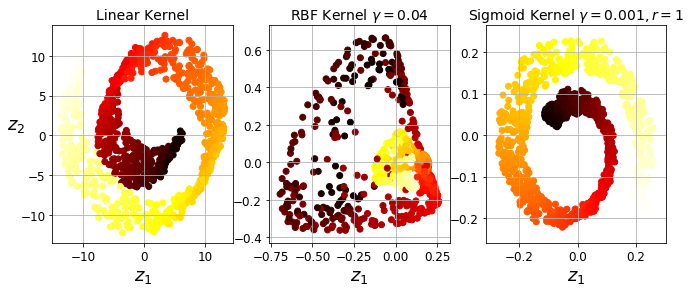

In [129]:
plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, lin_pca, 'Linear Kernel'), 
                           (132, rbf_pca, 'RBF Kernel $\gamma=0.04$'), 
                           (133, sig_pca, 'Sigmoid Kernel $\gamma=0.001, r=1$')):
    # Fit the kernel PCA to the data
    X_reduced = pca.fit_transform(X)
    
    # Remember the RBF kernel's reduced features - will use them later
    if subplot == 132:
        X_reduced_rbf = X_reduced 
        
    # Plot
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], 
                X_reduced[:, 1],
                c=t, cmap=plt.cm.hot)
    plt.xlabel('$z_1$', fontsize=18)
    
    # Add a ylabel only for the first plot
    if subplot == 131:
        plt.ylabel('$z_2$', fontsize=18, rotation=0)
    plt.grid(True)

# Save the figure
save_fig('kernel_pca_plot')
plt.show()

## Finding the Optimal Kernel

- PCA is unsupervised: there is no "right" or "wrong" answer per se when we're reducing dimensionality.
- However, this doesn't mean that the a specific PCA kernel won't transform the data in a way that improves - or degrades - performance.
- So technically, we can treat the PCA kernel as a hyperparameter in a supervised learning problem.
- The PCA is treated as a data preparation step using a `Pipeline` object. This is then combined with a machine learning model. 
- `GridSearchCV` can then be used to find the optimal kernels.

In [130]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV 
from sklearn.pipeline import Pipeline

In [132]:
# Create a pipeline - first applies RBF Kernel PCA, then fits using a LogReg Classifier
clf = Pipeline([
    ('kpca', KernelPCA(n_components=2)), 
    ('log_reg', LogisticRegression(solver='lbfgs'))
])

In [133]:
# Defining param grid to pass to GridSearchCV object - all params are for `kpca` object
param_grid = [{
    # Double underscore between kpca and next word - attribute of object!
    'kpca__gamma': np.linspace(0.03, 0.05, 10), 
    'kpca__kernel': ['rbf', 'sigmoid'],
}]

In [134]:
# Instantiating a GridSearchCV object for the `clf` with the specified param grid
grid_search = GridSearchCV(clf, param_grid, cv=3)

In [135]:
# Fit to the training data
grid_search.fit(X, y)

GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('kpca', KernelPCA(alpha=1.0, coef0=1, copy_X=True, degree=3, eigen_solver='auto',
     fit_inverse_transform=False, gamma=None, kernel='linear',
     kernel_params=None, max_iter=None, n_components=2, n_jobs=None,
     random_state=None, remove_zero_eig=False, tol=0)), ('log_reg', LogisticRe...enalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'kpca__gamma': array([0.03   , 0.03222, 0.03444, 0.03667, 0.03889, 0.04111, 0.04333,
       0.04556, 0.04778, 0.05   ]), 'kpca__kernel': ['rbf', 'sigmoid']}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [136]:
# Best PCA kernel?
print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


In [137]:
# Using KPCA with specified hyperparams
rbf_pca = KernelPCA(n_components=2, kernel='rbf', gamma=0.0433, fit_inverse_transform=True)
X_reduced = rbf_pca.fit_transform(X)

### Preimages 

When we were working with PCA before (technically KPCA with a linear kernel), we were using `SVD` to find the principal components matrix `Vt`, from which we derived `W_d`, a matrix, which when multiplied with the input features (`m` x `n`), transformed it to a `d`-dimensional matrix (`m` x `d`). 

We could find the original `m x n` data from the transformed data using an inverse transformation: `dot(X, W_n_transpose)`. 

Reconstructing the original data from the lower dimensional transformed data is not as straightforward in Kernel PCA because unlike standard PCA, kernel PCA (especially with RBF kernel) may map the original data to an infinite dimensional space before it is projected onto a lower dimensional space. If we were to try and use an `inverse_transform`, we'd map our `d`-dimensional data to an infinite dimensional space, not an `n`-dimensional space. 

The solution is to compute the **preimage** of the `d`-dimensional data: a point in the original `n` dimensional space that approximately corresponds to the same point in $\infty$-dimensional space.

In [138]:
X_preimage = rbf_pca.inverse_transform(X_reduced)

In [139]:
# Can measure the reconstruction error using the preimage, not the original image
from sklearn.metrics import mean_squared_error
mean_squared_error(X, X_preimage)

32.7863087957661

We can use `GridSearchCV` with `KernelPCA` to find the kernel that minimises the reconstruction error i.e. the MSE between the reconstructed preimage in the `n`-dimensional feature space and the original point in the `n`-dimensional feature space. 

Flow is as follows:
- Fitting: Original data `n`-dim -> Kernel PCA -> Infinite Dimensional Feature Space -> Reduced Space
- Reconstruction: Reduced Space -> Infinite Dimensional Feature Space -> Reconstruction Preimage in `n`-dim
- Reconstruction Error: `MSE(reconstructred_preimage, original_data)`.

# Locally Linear Embedding

In [146]:
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=41)

In [147]:
from sklearn.manifold import LocallyLinearEmbedding

In [148]:
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)

In [149]:
X_reduced = lle.fit_transform(X)

Saving figure lle_unrolling_plot


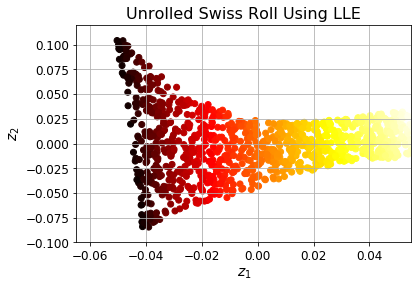

In [150]:
plt.title('Unrolled Swiss Roll Using LLE', fontsize=16)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel('$z_1$', fontsize=14)
plt.ylabel('$z_2$', fontsize=14)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

save_fig('lle_unrolling_plot')
plt.show()

# Other Embeddings

## MDS - Multidimensional Scaling 
Reduces dimensionality while trying to preserve the distances betwen the instances. 

In [151]:
from sklearn.manifold import MDS

In [152]:
mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X)

## Isomap
Creates a graph by connecting each instance to its nearest neighbours, then reduces dimensionality while trying to minimise geodesic distances between nodes i.e. number of nodes on the shortest path between these nodes.

In [154]:
from sklearn.manifold import Isomap

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X)

## t-Distributed Stochastic Neighbor Embedding (t-SNE)
- Reduces dimensionality while trying to keep similar instances close and dissimilar instances apart.
- Mostly used for visualization.

In [155]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced_tsne = tsne.fit_transform(X)

## Linear Discriminant Analysis - LDA
- Actually a supervised classification algorithm.
- Learns the most discriminative aces between classes, and these axes can then be used to define a hyperplane onto which data can be projected. 
- Benefit: projection will keep classes as far apart as possible.
- Useful as preprocessing for other classification algorithms such as SVM classifier.

In [156]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

lda = LinearDiscriminantAnalysis(n_components=2)
X_mnist = mnist['data']
y_mnist = mnist['target']
lda.fit(X_mnist, y_mnist)
X_reduced_lda = lda.transform(X_mnist)

/Users/saadmashkoor/.local/lib/python3.6/site-packages/sklearn/discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


## Comparing Dimensionality Reduction Techniques

Saving figure other_dim_reduction_plot


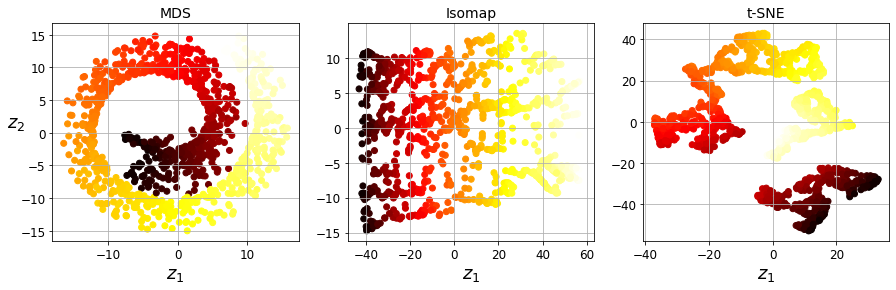

In [159]:
titles = ['MDS', 'Isomap', 't-SNE']

plt.figure(figsize=(15, 4))

for subplot, title, X_reduced in zip((131, 132, 133), titles, 
                                    (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel('$z_1$', fontsize=18)
    
    if subplot == 131:
        plt.ylabel('$z_2$', fontsize=18, rotation=0)
    
    plt.grid(True)
    
save_fig('other_dim_reduction_plot')
plt.show()